In [1]:
#!pip install syft

In [2]:
import syft as sy
from syft.core.node.new.util import autocache, PANDAS_DATA
sy.requires(">=0.8-beta")

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/koen/workspace/PySyft


✅ The installed version of syft==0.8.0b6 matches the requirement >=0.8b0


# Data owner: upload data

In [3]:
node = sy.orchestra.launch(name="pandas-test-domain-3", reset=True)

SQLite Store Path:
!open file:///var/folders/q1/ryq93kwj055dlbpngxv1c7z40000gn/T/7bca415d13ed1ec841f0d0aede098dbb.sqlite

> Starting Worker: test-domain-1 - 7bca415d13ed1ec841f0d0aede098dbb - NodeType.DOMAIN - [<class 'syft.core.node.new.user_service.UserService'>, <class 'syft.core.node.new.metadata_service.MetadataService'>, <class 'syft.core.node.new.action_service.ActionService'>, <class 'syft.core.node.new.test_service.TestService'>, <class 'syft.core.node.new.dataset_service.DatasetService'>, <class 'syft.core.node.new.user_code_service.UserCodeService'>, <class 'syft.core.node.new.request_service.RequestService'>, <class 'syft.core.node.new.data_subject_service.DataSubjectService'>, <class 'syft.core.node.new.network_service.NetworkService'>, <class 'syft.core.node.new.policy_service.PolicyService'>, <class 'syft.core.node.new.message_service.MessageService'>, <class 'syft.core.node.new.project_service.ProjectService'>, <class 'syft.core.node.new.data_subject_member_service.Data

In [4]:
domain_client = node.login(email="info@openmined.org", password="changethis")

In [5]:
# The usual preamble
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

plt.rcParams['figure.figsize'] = (15, 5)

## Load data

We're going to use a new dataset here, to demonstrate how to deal with larger datasets. This is a subset of the of 311 service requests from NYC Open Data.

In [6]:
# because of mixed types we specify dtype to prevent any errors
complaints = pd.read_csv(autocache(f"{PANDAS_DATA}/311-service-requests.csv"), dtype='unicode')

Depending on your pandas version, you might see an error like "DtypeWarning: Columns (8) have mixed types". This means that it's encountered a problem reading in our data. In this case it almost certainly means that it has columns where some of the entries are strings and some are integers.

For now we're going to ignore it and hope we don't run into a problem, but in the long run we'd need to investigate this warning.

In [7]:
complaints

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,26589651,10/31/2013 02:08:41 AM,NaN,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Talking,Street/Sidewalk,11432,90-03 169 STREET,169 STREET,90 AVENUE,91 AVENUE,NaN,NaN,ADDRESS,JAMAICA,NaN,Precinct,Assigned,10/31/2013 10:08:41 AM,10/31/2013 02:35:17 AM,12 QUEENS,QUEENS,1042027,197389,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.70827532593202,-73.79160395779721,"(40.70827532593202, -73.79160395779721)"
1,26593698,10/31/2013 02:01:04 AM,NaN,NYPD,New York City Police Department,Illegal Parking,Commercial Overnight Parking,Street/Sidewalk,11378,58 AVENUE,58 AVENUE,58 PLACE,59 STREET,NaN,NaN,BLOCKFACE,MASPETH,NaN,Precinct,Open,10/31/2013 10:01:04 AM,NaN,05 QUEENS,QUEENS,1009349,201984,Unspecified,QUEENS,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.721040535628305,-73.90945306791765,"(40.721040535628305, -73.90945306791765)"
2,26594139,10/31/2013 02:00:24 AM,10/31/2013 02:40:32 AM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,10032,4060 BROADWAY,BROADWAY,WEST 171 STREET,WEST 172 STREET,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,10/31/2013 10:00:24 AM,10/31/2013 02:39:42 AM,12 MANHATTAN,MANHATTAN,1001088,246531,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.84332975466513,-73.93914371913482,"(40.84332975466513, -73.93914371913482)"
3,26595721,10/31/2013 01:56:23 AM,10/31/2013 02:21:48 AM,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Horn,Street/Sidewalk,10023,WEST 72 STREET,WEST 72 STREET,COLUMBUS AVENUE,AMSTERDAM AVENUE,NaN,NaN,BLOCKFACE,NEW YORK,NaN,Precinct,Closed,10/31/2013 09:56:23 AM,10/31/2013 02:21:10 AM,07 MANHATTAN,MANHATTAN,989730,222727,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.7780087446372,-73.98021349023975,"(40.7780087446372, -73.98021349023975)"
4,26590930,10/31/2013 01:53:44 AM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Condition Attracting Rodents,Vacant Lot,10027,WEST 124 STREET,WEST 124 STREET,LENOX AVENUE,ADAM CLAYTON POWELL JR BOULEVARD,NaN,NaN,BLOCKFACE,NEW YORK,NaN,NaN,Pending,11/30/2013 01:53:44 AM,10/31/2013 01:59:54 AM,10 MANHATTAN,MANHATTAN,998815,233545,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.80769092704951,-73.94738703491433,"(40.80769092704951, -73.94738703491433)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111064,26426013,10/04/2013 12:01:13 AM,10/07/2013 04:07:16 PM,DPR,Department of Parks and Recreation,Maintenance or

## Create Mock data

In [8]:
from syft.core.node.new.mock import CachedFaker
from random import randint
import random

Let's create the mock data for the complaint dataset.

In [9]:
fake = CachedFaker()

In [10]:
fake_functions = {
    "Unique Key": lambda x: randint(1,1000000),
    "Location": lambda x: (fake.coordinate(), fake.coordinate()),
    "Agency": lambda x: random.choice(["NYPD", "DOHMH", "DPR"]),
    "X Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Y Coordinate (State Plane)": lambda x: randint(1,1000000),
    "Complaint Type": lambda x: random.choice(["Illegal Parking", "Noise - Street/Sidewalk", "'Animal in a Park'"]),
    "Descriptor": lambda x: random.choice([ 'Branch or Limb Has Fallen Down','Branches Damaged','Broken Fence', 'Broken Glass']),
    "School Number": lambda x: random.choice([ 'B073', 'B077', 'B079', 'B080-01', 'B087', 'B099', 'B100', 'B102', 'B109', 'B111']),
    "Bridge Highway Segment": lambda x: random.choice([ 'Grand Central Pkwy (Exit 1 E-W)',
                                                       'Grand Central Pkwy (Exit 10) - 69th Rd-Jewel Ave (Exit 11)',
                                                       'GrandCentral Pkwy/VanWyck Expwy/College Point Blvd (Exit 22 A-E)',
                                                       'Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278) (Exit 1)',
                                                       'Harding Ave (Exit 9) - Throgs Neck Br'])
}

In [11]:
fake_triggers = {
    "Street": lambda x : fake.street_name(),
    "Date": lambda x : fake.date_time(),
    "Long": lambda x : fake.coordinate(),
    "Lat": lambda x : fake.coordinate(),
    "Address": lambda x : fake.address(),
    "Name": lambda x : fake.name(),
    "City": lambda x : fake.city(),
    "Zip": lambda x : fake.zipcode(),
}

In [12]:
mock_data = dict()
for col in complaints.columns:
    col_vals = complaints[col]
    
    if col in fake_functions:
        mock_func = fake_functions[col]
    elif len(set(complaints[col])) < 100:
        values = list(set(complaints[col]))
        mock_func = lambda x: random.choice(values)
    else:
        for trigger in fake_triggers.keys():
            if trigger in col:
                mock_func = fake_triggers[trigger]
    mock_data[col] = [mock_func(None) for x in range(len(complaints))]

In [13]:
mock = pd.DataFrame(data=mock_data)

In [14]:
mock.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,965288,2017-04-12 15:17:55,1989-12-02 13:34:43,DPR,Monica Medina MD,Illegal Parking,Broken Glass,Other (explain in Complaint Details),41809,"994 Burns Square\nNorth Thomas, IA 52252",Barry Williamson,Herman Ridges,Hernandez Mountain,Robert Lodge,David Falls,LATLONG,Kellymouth,GRAND CENTRAL TERM,School,Pending,1990-01-28 05:19:03,1996-10-14 07:56:23,01 STATEN ISLAND,BRONX,558014,437465,Catherine Whitehead,QUEENS,John Wolf,B077,Region 2,NaN,7187568400,"9924 Matthew Walk\nNorth Robertport, VI 67280",MIDDLE VILLAGE,NY,27369,NaN,NaN,Car Service,BROOKLYN,Port Authority Bus Terminal,Eastern Blvd Br - Edgewater Rd,West/Staten Island Bound,Roadway,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Broome and Ludlow Field,Staten Island Bound,STEIN SENIOR CENTER,-115.298064,-96.511121,"(-40.716008, -49.142516)"
1,828852,2000-12-20 04:49:59,2023-02-27 22:00:36,DPR,Crystal Johnson,Illegal Parking,Broken Fence,Service Provider,53032,"9370 Anthony Brooks Apt. 895\nSouth Wyatt, NY ...",Deborah Wyatt,Jocelyn Estates,Denise Mall,Jason Oval,Rachel Forge,BLOCKFACE,Bryanmouth,INWOOD HILL PARK,NaN,Started,1986-09-26 07:41:59,2008-08-22 21:58:10,28 BRONX,QUEENS,635173,483141,Dr. Lindsey Hodges,QUEENS,Erik Reid,B073,Region 5,18K066,7187568400,"90018 Jonathan Pine\nAmandaborough, OK 36859",QUEENS VILLAGE,Unspecified,86382,NaN,NaN,NaN,MANHATTAN,Grand Central Station,Kosciuszko Br - BQE,West/Toward Triborough Br,Ramp,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Flushing #3 Field,Staten Island Bound,PROJECT FIND WOODSTOCK SENIOR CENTER,-125.889846,-70.537379,"(-100.121204, -49.142516)"
2,1717,1986-11-04 08:17:12,1989-12-02 13:34:43,NYPD,Matthew Newton,Illegal Parking,Branches Damaged,Residential Building/House,62511,"3182 Angelica Land Suite 347\nSouth James, DC ...",Amanda Burns,Barr Summit,Allen Underpass,Tina Throughway,Johnson Road,BLOCKFACE,Donnaton,CITY COLLEGE,School,Started,2008-01-03 06:43:48,2021-11-10 23:09:48,04 BROOKLYN,MANHATTAN,651512,81482,John Frank,BROOKLYN,Mark Mckinney,B080-01,Region 8,12X217,2124472020,"97710 Jones Drive Apt. 947\nSouth James, NH 40230",Unspecified,NY,41211,N,NaN,NaN,QUEENS,Grand Central Station,Alexander Hamilton/I-95 Cross Bronx Br,Manhattan Bound,Ramp,GrandCentral Pkwy/VanWyck Expwy/College Point ...,Brighton Beach Field,Manhattan Bound,Molinari,129.806132,147.119110,"(-79.204616, 168.662074)"
3,973461,1999-08-07 21:31:20,2009-03-12 02:33:38,NYPD,Jennifer Hall,Illegal Parking,Broken Fence,Government Building,69838,"757 Jared Forks\nTaylortown, IN 56999",Traci Jackson,Hart Square,Gray Road,Denise Mall,Jessica Club,ADDRESS,East Elizabeth,BETH ISRAEL MED CENTER,DSNY Garage,Assigned,2005-01-15 23:13:30,1992-06-04 21:25:58,64 MANHATTAN,STATEN ISLAND,916693,887370,Pamela Riley,STATEN ISLAND,Timothy Jennings,B109,Region 9,31R030,7189966666,USCGC Nelson\nFPO AA 17480,MIDDLE VILLAGE,Unspecified,51702,NaN,NaN,Ambulette / Paratransit,QUEENS,NaN,Grand Central Pkwy,NaN,Ramp,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Sheepshead Bay #1 Field,NaN,JEWISH ASSOCIATION FOR SERVICES FOR THE AGED (...,72.516758,103.450208,"(-98.105828, -40.716008)"
4,132612,1975-09-02 22:02:10,1996-06-17 10:20:02,NYPD,Joseph Davis,Noise - Street/Sidewalk,Broken 

In [15]:
dataset = sy.Dataset(name="test",
                     asset_list=[sy.Asset(name="complaints", data=complaints, mock=mock, mock_is_real=False)])
domain_client.upload_dataset(dataset)


  0%|                                                                                                                 | 0/1 [00:00<?, ?it/s]

Uploading: complaints


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.48s/it]


<class 'syft.core.node.new.response.SyftSuccess'>: Dataset Added

## Create data scientist

In [16]:
user = domain_client.register(name="Jane Doe", email="jane@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")

# todo: give user data scientist role

guest_domain_client = node.client

guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

# Data scientist: Create syft_function

## Download mock and submit project

### Get mock

In [17]:
guest_domain_client = node.client
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

In [18]:
ds = guest_domain_client.datasets[0]

In [19]:
asset = ds.assets["complaints"]

In [20]:
complaints = asset.mock

### Selecting only noise complaints


I'd like to know which borough has the most noise complaints. First, we'll take a look at the data to see what it looks like:

In [21]:
complaints[:5]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,965288,2017-04-12 15:17:55,1989-12-02 13:34:43,DPR,Monica Medina MD,Illegal Parking,Broken Glass,Other (explain in Complaint Details),41809,"994 Burns Square\nNorth Thomas, IA 52252",Barry Williamson,Herman Ridges,Hernandez Mountain,Robert Lodge,David Falls,LATLONG,Kellymouth,GRAND CENTRAL TERM,School,Pending,1990-01-28 05:19:03,1996-10-14 07:56:23,01 STATEN ISLAND,BRONX,558014,437465,Catherine Whitehead,QUEENS,John Wolf,B077,Region 2,None,7187568400,"9924 Matthew Walk\nNorth Robertport, VI 67280",MIDDLE VILLAGE,NY,27369,None,NaN,Car Service,BROOKLYN,Port Authority Bus Terminal,Eastern Blvd Br - Edgewater Rd,West/Staten Island Bound,Roadway,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Broome and Ludlow Field,Staten Island Bound,STEIN SENIOR CENTER,-115.298064,-96.511121,"[-40.716008, -49.142516]"
1,828852,2000-12-20 04:49:59,2023-02-27 22:00:36,DPR,Crystal Johnson,Illegal Parking,Broken Fence,Service Provider,53032,"9370 Anthony Brooks Apt. 895\nSouth Wyatt, NY ...",Deborah Wyatt,Jocelyn Estates,Denise Mall,Jason Oval,Rachel Forge,BLOCKFACE,Bryanmouth,INWOOD HILL PARK,None,Started,1986-09-26 07:41:59,2008-08-22 21:58:10,28 BRONX,QUEENS,635173,483141,Dr. Lindsey Hodges,QUEENS,Erik Reid,B073,Region 5,18K066,7187568400,"90018 Jonathan Pine\nAmandaborough, OK 36859",QUEENS VILLAGE,Unspecified,86382,None,NaN,None,MANHATTAN,Grand Central Station,Kosciuszko Br - BQE,West/Toward Triborough Br,Ramp,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Flushing #3 Field,Staten Island Bound,PROJECT FIND WOODSTOCK SENIOR CENTER,-125.889846,-70.537379,"[-100.121204, -49.142516]"
2,1717,1986-11-04 08:17:12,1989-12-02 13:34:43,NYPD,Matthew Newton,Illegal Parking,Branches Damaged,Residential Building/House,62511,"3182 Angelica Land Suite 347\nSouth James, DC ...",Amanda Burns,Barr Summit,Allen Underpass,Tina Throughway,Johnson Road,BLOCKFACE,Donnaton,CITY COLLEGE,School,Started,2008-01-03 06:43:48,2021-11-10 23:09:48,04 BROOKLYN,MANHATTAN,651512,81482,John Frank,BROOKLYN,Mark Mckinney,B080-01,Region 8,12X217,2124472020,"97710 Jones Drive Apt. 947\nSouth James, NH 40230",Unspecified,NY,41211,N,NaN,None,QUEENS,Grand Central Station,Alexander Hamilton/I-95 Cross Bronx Br,Manhattan Bound,Ramp,GrandCentral Pkwy/VanWyck Expwy/College Point ...,Brighton Beach Field,Manhattan Bound,Molinari,129.806132,147.119110,"[-79.204616, 168.662074]"
3,973461,1999-08-07 21:31:20,2009-03-12 02:33:38,NYPD,Jennifer Hall,Illegal Parking,Broken Fence,Government Building,69838,"757 Jared Forks\nTaylortown, IN 56999",Traci Jackson,Hart Square,Gray Road,Denise Mall,Jessica Club,ADDRESS,East Elizabeth,BETH ISRAEL MED CENTER,DSNY Garage,Assigned,2005-01-15 23:13:30,1992-06-04 21:25:58,64 MANHATTAN,STATEN ISLAND,916693,887370,Pamela Riley,STATEN ISLAND,Timothy Jennings,B109,Region 9,31R030,7189966666,USCGC Nelson\nFPO AA 17480,MIDDLE VILLAGE,Unspecified,51702,None,NaN,Ambulette / Paratransit,QUEENS,None,Grand Central Pkwy,None,Ramp,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Sheepshead Bay #1 Field,None,JEWISH ASSOCIATION FOR SERVICES FOR THE AGED (...,72.516758,103.450208,"[-98.105828, -40.716008]"
4,132612,1975-09-02 22:02:10,1996-06-17 10:20:02,NYPD,Joseph Davis,Noise - Street/Sidewa

To get the noise complaints, we need to find the rows where the "Complaint Type" column is "Noise - Street/Sidewalk". I'll show you how to do that, and then explain what's going on.



In [22]:
noise_complaints = complaints[complaints['Complaint Type'] == "Noise - Street/Sidewalk"]
noise_complaints[:3]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
4,132612,1975-09-02 22:02:10,1996-06-17 10:20:02,NYPD,Joseph Davis,Noise - Street/Sidewalk,Broken Fence,Public/Unfenced Area,03974,"245 Brandi Key Suite 500\nJonathanstad, NJ 10743",Caleb Davis,Shah Tunnel,Christine Mountains,Ford Locks,Monica Spurs,BLOCKFACE,Scottland,JFK,None,Started,1996-06-17 10:20:02,2012-12-05 20:48:19,15 BROOKLYN,QUEENS,41952,307949,Sheila Rios,QUEENS,Margaret Rogers,B111,Region 8,12X217,Unspecified,"PSC 5917, Box 7594\nAPO AA 35813",FRESH MEADOWS,Unspecified,73669,Y,NaN,Ambulette / Paratransit,STATEN ISLAND,JFK Airport,Bronx River Pkwy,South/New Jersey Bound,Ramp,Grand Central Pkwy (Exit 1 E-W),Steinway #1 and #2 Field,Manhattan Bound,JOSE URBAEZ,-62.648485,42.410615,"[-70.537379, -79.204616]"
9,633712,2008-05-06 18:22:02,1971-12-03 14:15:23,DOHMH,Margaret Rogers,Noise - Street/Sidewalk,Broken Glass,Bus Stop Shelter,27369,"961 Andrea Isle Suite 690\nContrerasville, MO ...",Robert Sims,Eric View,Hodges Plaza,David Falls,Robert Lodge,ADDRESS,South Jessicachester,J F K AIRPORT,None,Unassigned,1998-09-01 22:23:23,2005-11-21 14:55:20,09 MANHATTAN,MANHATTAN,566149,465162,James Hernandez,QUEENS,Victor Lee,B111,Region 1,06M223,7188224282,"38278 Henry Key\nPorterfurt, NH 66355",BELLEROSE,Unspecified,72299,Y,NaN,Car Service,None,Intersection,Staten Island Expwy,South/Manhattan Bound,Roadway,Hamilton Ave (Exit 2A) - Gowanus Expwy (I-278)...,Bayside Field,Manhattan Bound,Molinari,55.875355,72.516758,"[-153.890424, -2.315138]"
12,766921,1996-10-14 07:56:23,1991-04-14 18:19:42,DOHMH,Eric Walker,Noise - Street/Sidewalk,Broken Glass,Day Care/Nursery,56279,"190 Rodriguez Ramp\nWeberton, IL 37467",Jennifer Cunningham,Jones Estates,Lawrence Via,Eric View,Fox Junction,BLOCKFACE,New Penny,WASHINGTON SQUARE PARK,School,Unassigned,2008-10-03 16:00:40,1999-08-07 21:31:20,06 QUEENS,BRONX,511783,537485,Christine Warren,MANHATTAN,Joseph Schneider,B111,Region 10,02M001,2126464100,"121 Gibson Keys Apt. 687\nSouth Devin, FL 24442",FLUSHING,NY,08265,None,NaN,Car Service,QUEENS,Other,Eastern Blvd Br - Edgewater Rd,Southbound/To OuterBr Cr,None,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,SI Ferry Terminal,Manhattan Bound,HUGH GILROY SENIOR CENTER,-73.144420,90.131645,"[108.161820, -70.537379]"


If you look at noise_complaints, you'll see that this worked, and it only contains complaints with the right complaint type. But how does this work? Let's deconstruct it into two pieces

In [23]:
complaints['Complaint Type'] == "Noise - Street/Sidewalk"

0         False
1         False
2         False
3         False
4          True
          ...  
111064    False
111065    False
111066     True
111067    False
111068    False
Name: Complaint Type, Length: 111069, dtype: bool

This is a big array of Trues and Falses, one for each row in our dataframe. When we index our dataframe with this array, we get just the rows where our boolean array evaluated to True. It's important to note that for row filtering by a boolean array the length of our dataframe's index must be the same length as the boolean array used for filtering.

You can also combine more than one condition with the & operator like this:

In [24]:
is_noise = (complaints['Complaint Type'] == "Noise - Street/Sidewalk")
in_brooklyn = complaints['Borough'] == "BROOKLYN"
complaints[is_noise & in_brooklyn][:5]

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
54,945937,1978-05-17 18:55:21,2010-09-18 21:01:20,DPR,Adriana Jones,Noise - Street/Sidewalk,Broken Glass,School,96613,"6269 Patel Street\nWalterland, RI 32439",John Frank,Michael Terrace,Johnson Road,Hernandez Mountain,Travis Shores,PLACENAME,Wilsonhaven,METROPOLITAN MUSEUM,DSNY Garage,Open,1986-10-17 17:53:16,2010-09-18 21:01:20,82 QUEENS,BROOKLYN,840280,733534,Mark Mckinney,Unspecified,Emily Davis,B073,Region 1,01M361,7187223213,"7508 Lisa Plain Apt. 578\nPort Ashley, CT 92163",RIDGEWOOD,NY,44649,N,NaN,Ambulette / Paratransit,MANHATTAN,New York-Penn Station,Throgs Neck Expwy,South/East (To Throgs Neck Br),None,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,White Plains Road Field,Manhattan Bound,DORIS GREEN,31.850218,-62.648485,"[116.947028, 5.304791]"
71,845151,1984-03-12 01:16:45,2008-08-22 21:58:10,NYPD,Philip Rodriguez,Noise - Street/Sidewalk,Broken Fence,1-2 Family Mixed Use Building,17439,"0183 Jones Keys Suite 430\nJosephmouth, WV 95438",Brian Valentine,Daniel Passage,Moyer Avenue,Baker Extension,Baker Extension,BLOCKFACE,Michaelview,JFK,DSNY Garage,Assigned,2010-09-18 21:01:20,2006-12-07 09:48:15,02 MANHATTAN,BROOKLYN,900134,483798,Caleb Davis,BROOKLYN,Felicia Lang,B077,Unspecified,27Q197,7187201010,"96842 Stacey Point Apt. 605\nMichaelside, AK 0...",FLUSHING,Unspecified,03934,None,NaN,Ambulette / Paratransit,BROOKLYN,Intersection,Manhattan Br,North/Eastbound,Ramp,Grand Central Pkwy (Exit 10) - 69th Rd-Jewel A...,Far Rockaway #2 Field,Manhattan Bound,BRIGID OCONNOR,42.410615,103.450208,"[112.827054, 5.304791]"
76,888246,1989-07-11 10:58:20,1980-04-03 06:46:49,DPR,Traci Jackson,Noise - Street/Sidewalk,Branches Damaged,Restaurant,61465,"11411 Schroeder Hill\nLake John, NJ 27326",Alexandra Mckinney,Reed Tunnel,Solis Light,Gray Road,Garner Causeway,BLOCKFACE,New Maurice,MUSEUM NATURAL HIST,School,Open,1976-08-30 03:22:38,1991-12-26 15:08:12,27 BRONX,BROOKLYN,946315,439851,Victor Lee,BRONX,Robert Johnson,B100,Region 10,02M281,7183782061,"921 Turner Rapid\nNew Susanhaven, WA 07364",REGO PARK,Unspecified,19705,None,NaN,Ambulette / Paratransit,QUEENS,New York-Penn Station,Washington Br/181 Street Br.,Southbound/To OuterBr Cr,Roadway,GrandCentral Pkwy/VanWyck Expwy/College Point ...,Flushing #1 Field,None,Molinari,155.424625,-158.859935,"[-107.403554, -163.829469]"
89,995439,1991-04-14 18:19:42,1994-01-16 10:42:26,DPR,Lori Harvey,Noise - Street/Sidewalk,Branches Damaged,NYC Street Address,76220,"00936 Mcpherson Isle\nDayview, OR 77203",Alan Simmons,Monica Spurs,Herman Ridges,Clinton Ramp,Matthew Flat,None,North Ronaldhaven,MUSEUM NATURAL HIST,DSNY Garage,Closed,1979-10-28 12:22:10,1983-09-20 01:32:15,07 QUEENS,BROOKLYN,991494,846803,John Frank,MANHATTAN,Tiffany Harrell,B073,Region 5,22K207,7187201010,"964 Jacqueline Inlet\nSouth Martha, SC 56696",EAST ELMHURST,NY,03974,N,NaN,None,BROOKLYN,None,BQE/Gowanus Expwy,Westbound,None,Harding Ave (Exit 9) - Throgs Neck Br,Brighton Beach Field,Staten Island Bound,EDITH S. RING,37.236762,-117.995173,"[39.515069, 166.747940]"
93,805897,1986-09-26 07:41:59,1991-03-25 09:31:05,DOHMH,Dana Franklin,Noise - Street/Sidewalk,Broken Glass,Pier,80383,"PSC 8294, Box 6925\nAPO AA 41175",Jacob Sanders,Phillips Falls,Bo

Or if we just wanted a few columns:



In [25]:
complaints[is_noise & in_brooklyn][['Complaint Type', 'Borough', 'Created Date', 'Descriptor']][:10]

,Complaint Type,Borough,Created Date,Descriptor
54,Noise - Street/Sidewalk,BROOKLYN,1978-05-17 18:55:21,Broken Glass
71,Noise - Street/Sidewalk,BROOKLYN,1984-03-12 01:16:45,Broken Fence
76,Noise - Street/Sidewalk,BROOKLYN,1989-07-11 10:58:20,Branches Damaged
89,Noise - Street/Sidewalk,BROOKLYN,1991-04-14 18:19:42,Branches Damaged
93,Noise - Street/Sidewalk,BROOKLYN,1986-09-26 07:41:59,Broken Glass
116,Noise - Street/Sidewalk,BROOKLYN,1992-06-06 00:51:57,Broken Glass
134,Noise - Street/Sidewalk,BROOKLYN,2003-04-08 00:42:18,Broken Glass
152,Noise - Street/Sidewalk,BROOKLYN,1978-05-17 18:55:21,Broken Glass
158,Noise - Street/Sidewalk,BROOKLYN,1971-12-03 14:15:23,Branch or Limb Has Fallen Down
177,Noise - Street/Sidewalk,BROOKLYN,2020-05-13 16:32:34,Broken Fence


### A digression about numpy arrays

On the inside, the type of a column is pd.Series

In [26]:
import pandas as pd
import numpy as np

In [27]:
pd.Series([1,2,3])

0    1
1    2
2    3
dtype: int64

and pandas Series are internally numpy arrays. If you add .values to the end of any Series, you'll get its internal numpy array

In [28]:
np.array([1,2,3])

array([1, 2, 3])

In [29]:
pd.Series([1,2,3]).values

array([1, 2, 3])

So this binary-array-selection business is actually something that works with any numpy array:

In [30]:
arr = np.array([1,2,3])

In [31]:
arr != 2

array([ True, False,  True])

In [32]:
arr[arr != 2]

array([1, 3])

### So, which borough has the most noise complaints?

In [33]:
is_noise = complaints['Complaint Type'] == "Noise - Street/Sidewalk"
noise_complaints = complaints[is_noise]
noise_complaints['Borough'].value_counts()

MANHATTAN        6130
BROOKLYN         6130
STATEN ISLAND    6123
Unspecified      6106
BRONX            6057
QUEENS           6036
Name: Borough, dtype: int64

It's the BRONX (for this Mock)! But what if we wanted to divide by the total number of complaints, to make it make a bit more sense? That would be easy too:

In [34]:
noise_complaint_counts = noise_complaints['Borough'].value_counts()
complaint_counts = complaints['Borough'].value_counts()

In [35]:
noise_complaint_counts

MANHATTAN        6130
BROOKLYN         6130
STATEN ISLAND    6123
Unspecified      6106
BRONX            6057
QUEENS           6036
Name: Borough, dtype: int64

In [36]:
noise_complaint_counts / complaint_counts

BRONX            0.329615
BROOKLYN         0.329818
MANHATTAN        0.330067
QUEENS           0.329656
STATEN ISLAND    0.327206
Unspecified      0.329840
Name: Borough, dtype: float64

Oops, why was that zero? That's no good. This is because of integer division in Python 2. Let's fix it, by converting complaint_counts into an array of floats.

In [37]:
noise_complaint_counts / complaint_counts.astype(float)

BRONX            0.329615
BROOKLYN         0.329818
MANHATTAN        0.330067
QUEENS           0.329656
STATEN ISLAND    0.327206
Unspecified      0.329840
Name: Borough, dtype: float64

<AxesSubplot: >

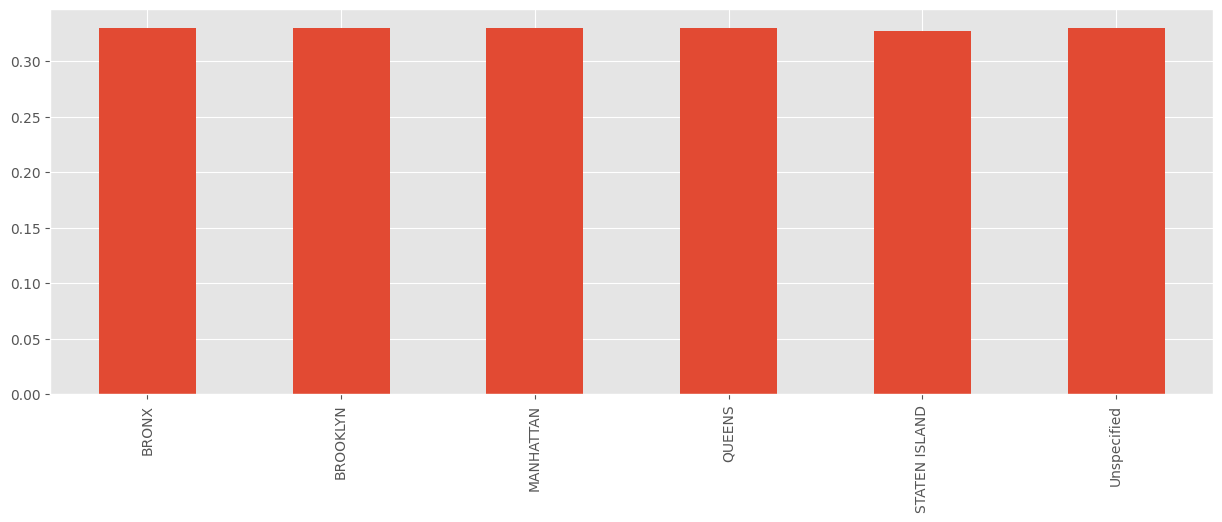

In [38]:
(noise_complaint_counts / complaint_counts.astype(float)).plot(kind='bar')

So Bronx really does complain more about noise than the other boroughs in our mock! Neat.

## Request real result

Now that we finished our analysis on the mock data, we can request this execution on the real data.

In [39]:
@sy.syft_function(input_policy=sy.ExactMatch(complaints=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_counts(complaints):
    is_noise = complaints['Complaint Type'] == "Noise - Street/Sidewalk"
    noise_complaints = complaints[is_noise]
    noise_complaint_counts = noise_complaints['Borough'].value_counts()
    complaint_counts = complaints['Borough'].value_counts()
    return noise_complaint_counts / complaint_counts.astype(float)

Request code execution

In [40]:
req = guest_domain_client.api.services.code.request_code_execution(get_counts)

In [41]:
submitted_code = guest_domain_client.code[0]

In [42]:
assert guest_domain_client.api.services.code.get_all()

Create and submit project

In [43]:
new_project = sy.Project(name="Pandas chapter 3",
                         description="Hi, I would like to plot the histogram of the noise complaint counts per area.")

In [44]:
new_project.add_request(obj=submitted_code, permission=sy.UserCodeStatus.EXECUTE)

In [45]:
guest_domain_client.submit_project(new_project)

<class 'syft.core.node.new.response.SyftSuccess'>: Project Submitted

# Data owner: execute function

In [46]:
from syft import Worker, MessageStatus
from syft.core.node.new.project import Project

## Get messages

In [47]:
domain_client = node.login(email="info@openmined.org", password="changethis")

In [48]:
messages = domain_client.api.services.messages.get_all_for_status(MessageStatus.UNDELIVERED)

In [49]:
messages

,type,id,subject,status,created_at,linked_obj
0,syft.core.node.new.messages.Message,d944d95ca4384c7bb9797f8272d8df28,Project Approval,MessageStatus.UNDELIVERED,2023-05-15 13:32:06,<<class 'syft.core.node.new.project.Project'>:...
1,syft.core.node.new.messages.Message,6c31ef2c37f445709d2c5c272127f40f,Approval Request,MessageStatus.UNDELIVERED,2023-05-15 13:32:05,<<class 'syft.core.node.new.request.Request'>:...


In [50]:
project_message = [x for x in messages if issubclass(x.linked_obj.object_type, Project)][0]

In [51]:
request = project_message.link.requests[0]
func = request.changes[0].link
op = func.output_policy_type

In [52]:
func

```python
class UserCode:
  id: str = 8ca1c4dd75124365ba089e7ddd9d8b2a
  node_uid: str = 7bca415d13ed1ec841f0d0aede098dbb
  user_verify_key: str = 6345c541104533bb1fa2939de00c139b64b99fa5900c9ea054d454436a276554
  raw_code: str = "@sy.syft_function(input_policy=sy.ExactMatch(complaints=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_counts(complaints):
    is_noise = complaints['Complaint Type'] == "Noise - Street/Sidewalk"
    noise_complaints = complaints[is_noise]
    noise_complaint_counts = noise_complaints['Borough'].value_counts()
    complaint_counts = complaints['Borough'].value_counts()
    return noise_complaint_counts / complaint_counts.astype(float)
"
  input_policy_type: str = <class 'syft.core.node.new.policy.ExactMatch'>
  input_policy_init_kwargs: str = {NodeView(node_name='test-domain-1', verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f): {'complaints': <UID: 055c65eaa4ca41688883cc74432e4d8f>}}
  input_policy_state: str = b''
  output_policy_type: str = <class 'syft.core.node.new.policy.OutputPolicyExecuteOnce'>
  output_policy_init_kwargs: str = {}
  output_policy_state: str = b''
  parsed_code: str = "

def user_func_get_counts_6345c541104533bb1fa2939de00c139b64b99fa5900c9ea054d454436a276554_701f23755a69b9f3f6d34d6a02c53686edbd4a524ddd4cb2d4815c33b33a5b20(complaints):

    def get_counts(complaints):
        is_noise = (complaints['Complaint Type'] == 'Noise - Street/Sidewalk')
        noise_complaints = complaints[is_noise]
        noise_complaint_counts = noise_complaints['Borough'].value_counts()
        complaint_counts = complaints['Borough'].value_counts()
        return (noise_complaint_counts / complaint_counts.astype(float))
    result = get_counts(complaints=complaints)
    return result
"
  service_func_name: str = "get_counts"
  unique_func_name: str = "user_func_get_counts_6345c541104533bb1fa2939de00c139b64b99fa5900c9ea054d454436a276554_701f23755a69b9f3f6d34d6a02c53686edbd4a524ddd4cb2d4815c33b33a5b20"
  user_unique_func_name: str = "user_func_get_counts_6345c541104533bb1fa2939de00c139b64b99fa5900c9ea054d454436a276554"
  code_hash: str = "701f23755a69b9f3f6d34d6a02c53686edbd4a524ddd4cb2d4815c33b33a5b20"
  signature: str = (complaints)
  status: str = {NodeView(node_name='test-domain-1', verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f): <UserCodeStatus.SUBMITTED: 'submitted'>}
  input_kwargs: str = ['complaints']
  enclave_metadata: str = None

```

In [53]:
get_counts_user_func = func.unsafe_function

In [54]:
real_data = domain_client.datasets[0].assets[0].data

In [55]:
real_result = get_counts_user_func(complaints=real_data)

In [56]:
real_result[:3]

BRONX        0.014833
BROOKLYN     0.013864
MANHATTAN    0.037755
Name: Borough, dtype: float64

In [57]:
result = request.accept_by_depositing_result(real_result)
result
assert isinstance(result, sy.SyftSuccess)

# Data scientist: fetch result

In [58]:
asset = guest_client.datasets[0].assets[0]

In [59]:
guest_client.api.services.code[0].status

{NodeView(node_name='test-domain-1', verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f): <UserCodeStatus.EXECUTE: 'execute'>}

<AxesSubplot: >

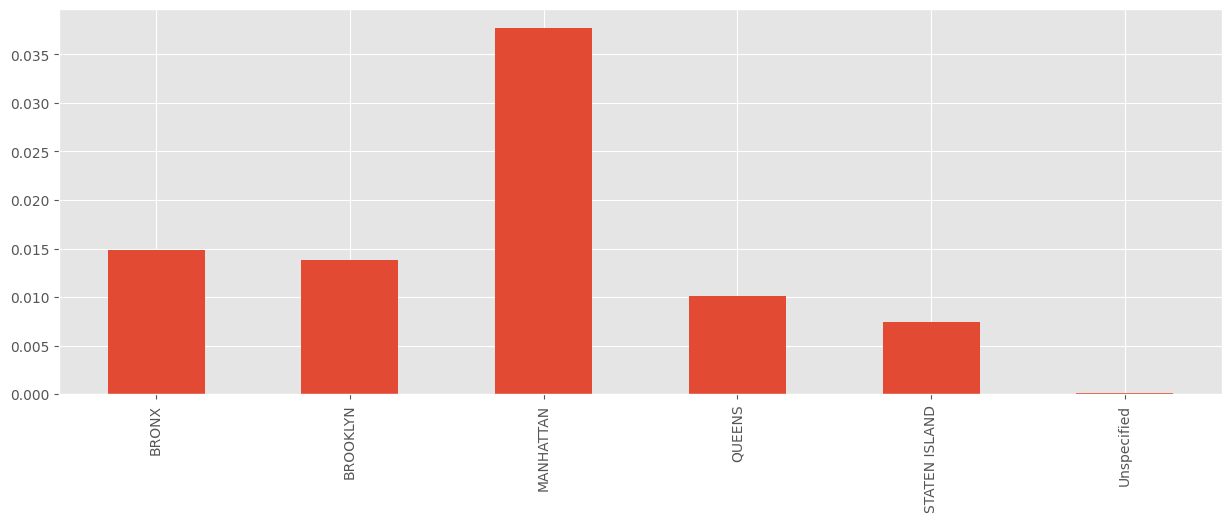

In [60]:
real_result = guest_client.api.services.code.get_counts(complaints=asset)
real_result.plot(kind="bar")